In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import warnings


from collections import OrderedDict
from pathlib import Path
from typing import List


warnings.filterwarnings("ignore")
sns.set_theme()

INPUT_DIR = r"..\energy\inputs\energy.dat"
OUTPUT_DIR = r"..\energy\output"

In [40]:
#@title Funcs
# ETL > Utils
def dataframe_from_dat_file(dir: str, sep=',') -> pd.DataFrame:
    assert isinstance(dir, str), '`dataframe_from_dir` expects filepath of type \
        String.'
    fpath_exists = os.path.exists(dir)
    assert fpath_exists, f'Not a valid filepath: {dir}'
    try:
        df = pd.read_csv(dir, sep=sep, index_col=0,
                         parse_dates=True, infer_datetime_format=True)
    except:
        df = pd.read_csv(dir, sep=sep)
    # Format
    df.columns = df.columns.str.lower()
    return df
    
# ETL > Utils
def dump_dataframe(file_output_path: str, 
                   df: pd.DataFrame, 
                   file_name: str = None,
                   suffix='.csv'):
    if file_name is None:
        FILENAME = 'data'
    else:
        FILENAME = file_name 
    # Create path if it does not exists
    path = Path(file_output_path + "/" + FILENAME)
    path.mkdir(parents=True, exist_ok=True)
    
    # Write out as CSV
    filepath = path / f'{FILENAME}{suffix}'
    df.to_csv(filepath)

# EDA > eda
def compute_feature_metadata(df: pd.DataFrame) -> pd.DataFrame:
    """Compute basic statistics.

    Args:
    df: A `pandas.core.DataFrame`.

    Returns:
    df: The basic metadata and statistics computed w.r.t input DataFrame.
    """
    assert isinstance(df, pd.DataFrame), '`compute_feature_metadata` expects an \
        input, `df` of type `Pandas.core.DataFrame`.'
    statistics = df.describe()
    statistics.loc['pct_missing'] = df.isnull().sum() / df.shape[0]
    return statistics

# EDA > eda
def ts_plot(y: pd.Series, lags=None):
    """Plot time series, its ACF and PACF, calculate Dickey–Fuller test. 
    Args:
        y: A `Pandas.core.Series'. The target observations.
        lags: A `Python` `list`. The number of lags/order of differencing to
            test for stationarity in computing the ACF, PACF.
    Returns:
       ts_plot: Obj. A `matplotlib` plot.
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=(12, 6))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), 
                             colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    # Plot Target
    y.plot(ax=ts_ax)

    # Compute ADF statistics
    test_result = sm.tsa.stattools.adfuller(y)
    adf = test_result[0]
    p_value = test_result[1]
    critical_value = test_result[4]['5%']
    
    if (p_value < 0.05) and (adf < critical_value):
        result = 'STATIONARY'
    else:
        result = 'NON-STATIONARY'
    ts_ax.set_title(
        f'Time Series Analysis Plot \
        \n Dickey-Fuller Test Stat Result: {result}')
    
    # Compute and plot ACF/PACF 
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

# EDA > eda
def seasonally_decompose_series(s: pd.Series, 
                                mod_class: str = 'seasonal_decompose',
                                *args, **kwargs):
    if mod_class == 'seasonal_decompose':
        # Seasonal decomposition using moving averages.
        dc_plot = sm.tsa.seasonal_decompose(s, **kwargs)
    elif mod_class == 'stl':
        # Seasonal decomposition using Locally Estimated Scatterplot Smoothing
        # (LOESS)
        dc_plot = sm.tsa.STL(s, **kwargs).fit()

    fig = dc_plot.plot()
    fig.set_size_inches((12, 9))
    fig.tight_layout()
    plt.show()

# EDA > eda
def compute_dist_properties_metadata(s: pd.Series):
    """Compute basic statistics w.r.t an input series of type `Pandas.core.Series`.

    Args:
       s: A `Pandas.core.Series`. The target observations.
    Returns:
       results_stats_df: A `Pandas.core.DataFrame`. The mean and variance \ 
           properties of the input observations.
    """

    s = df.values
    split_seq = round(len(s) / 2)
    seq_1, seq_2 = s[0: split_seq], s[split_seq:] 
    mean_1, mean_2 = seq_1.mean(), seq_2.mean() 
    var_1, var_2 = seq_1.var(), seq_2.var()

    # Store stats
    _results_dict = {
        'mean_1': mean_1,
        'variance_1': var_1,
        'mean_2': mean_2,
        'variance_2': var_2
    }

    # Results
    dist_stats_df = pd.DataFrame(_results_dict, index=[0])
    return dist_stats_df

# ETL 


*   Read .dat File
*   Extract metadata 
*   Determine basic statistics and imputation/missing observations strategy (if required)



In [17]:
# Read .dat ile 
df = dataframe_from_dat_file(INPUT_DIR,sep=",")
df.head(10)

,consumption
Date,
2015-04-01,357.073
2015-04-02,341.931
2015-04-03,318.777
2015-04-04,312.494
2015-04-05,270.837
2015-04-06,290.126
2015-04-07,296.189
2015-04-08,285.508
2015-04-09,251.327


<AxesSubplot:xlabel='Date'>

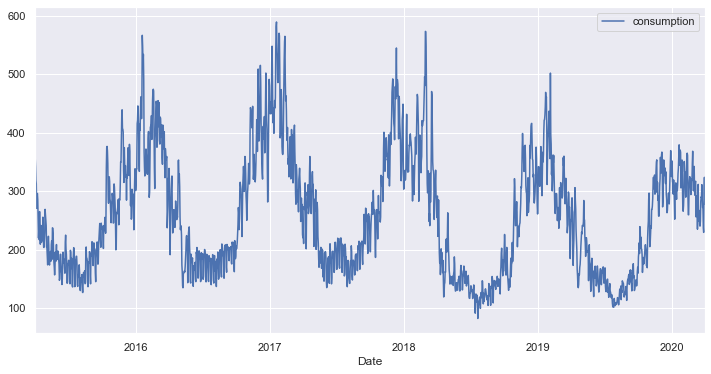

In [75]:
df.plot(figsize=(12, 6))

In [76]:
#Compute basic statistics
metadata = compute_feature_metadata(df)
metadata

,consumption
count,1827.000000
mean,257.885096
std,100.993368
min,82.675000
25%,174.672500
50%,242.719000
75%,327.841000
max,589.269000
pct_missing,0.000000


# EDA
- Determine target distributive properties & behaviour, such as outliers
- Perform decomposition to understand target integrants: Systematic & Non-Systematic:
- Seasonal, cyclical, trend and residual components
- Determine periodicity of above

<AxesSubplot:ylabel='Frequency'>

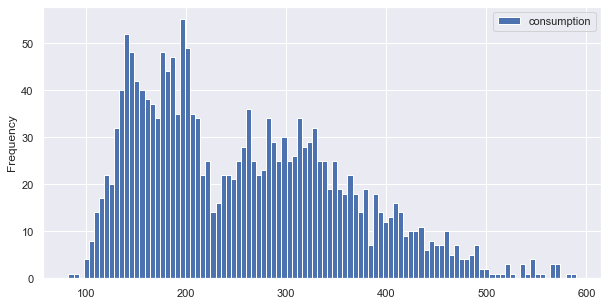

In [18]:
# Target distribution. 
df.plot(kind='hist', bins=100, figsize=(10, 5))

In [78]:
# Highly non-ergodic, non-stationary.
# Mean & Variance confirm data heavily non-gaussian/normal.
compute_dist_properties_metadata(df.values)

,mean_1,variance_1,mean_2,variance_2
0,265.132821,10125.294441,250.629434,10157.704494


#### Time Series Components Analysis


*  Order 1 differencing yields a stationary process. Confirmed by ADF test P-Value < 0.05.
*  Target appears ergodic with the exception of 2020 >.
*  Train/Val/Test split representation is a consideration as a result, since distributions of the aforementioned can prove to be non-representative.
*  A rolling training window (as opposed to expanding) can help address structural breaks and non-ergodic properties.

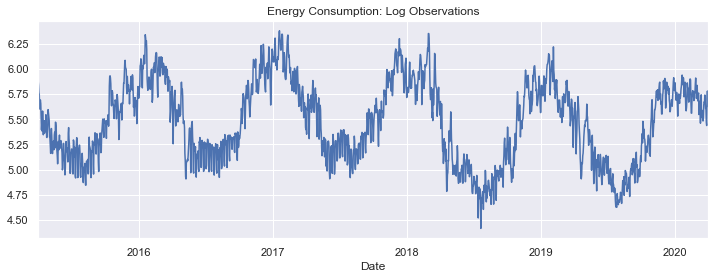

In [9]:
# Log observations.
log_ts = pd.Series(np.log(df.consumption))
plt.title('Energy Consumption: Log Observations')
log_ts.plot(figsize=(12, 4))
plt.show()

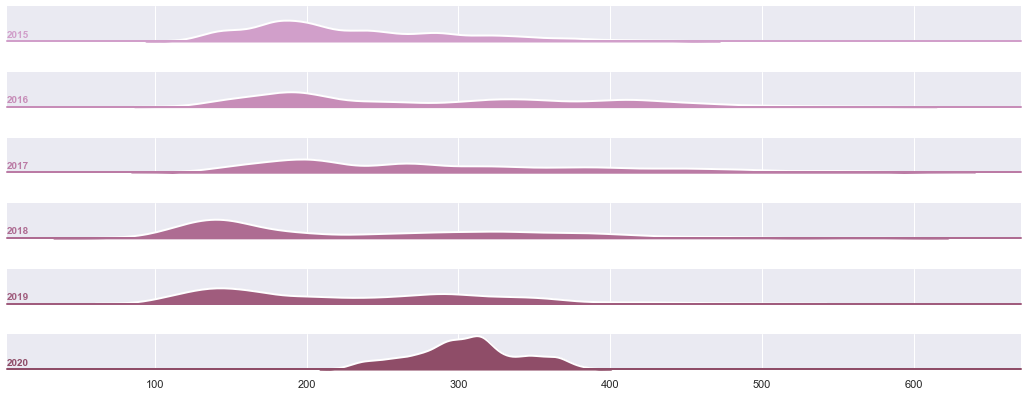

In [28]:
#@title Identify Annual Distribution Properties
# Get year identification
df['year'] = df.index.year

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, start=1, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="year", hue="year", aspect=15, height=1., palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "consumption",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

g.map(sns.kdeplot, "consumption", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "consumption")

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xlabel="", ylabel="")
g.despine(bottom=True, left=True)
plt.show()


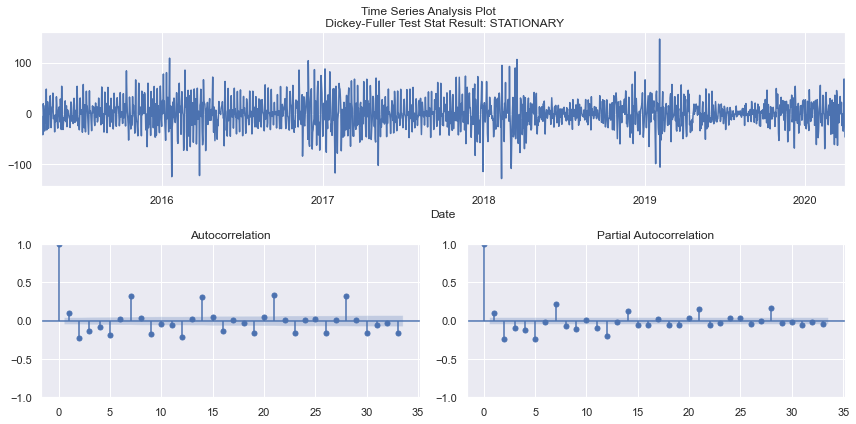

In [41]:
# Test order 1 differencing 
ts_plot(df.consumption.diff().dropna())

#### Seasonal Decomposition
* Simple decomposition fails to decompose the observed time-series. A more
power method using LOESS yields a more interpretable result.   
* Loess decomposition, specifically the trend components, illustrates the mean-reverting behaviour of the energy consumption series. Moreover, it can be noted that the process is globally stationary.  
*   It can be observed that the trend component can be modelled using a simple polynomial. 
*   Bounded variance residuals suggest that the seasonal component explains
a significant proportion of the variance. Moreover, a density plot of the residual components suggests that error is largely gaussian, however some outlier treatment might be required. 
*   Analysis suggests that the incorporation of endogenous seasonal features can help further explain the variance in the observed time-series.
* Accordingly, a statistical auto-regressive model, that can incorporate seasonal properties such as SARIMAX can serve as a robust baseline:



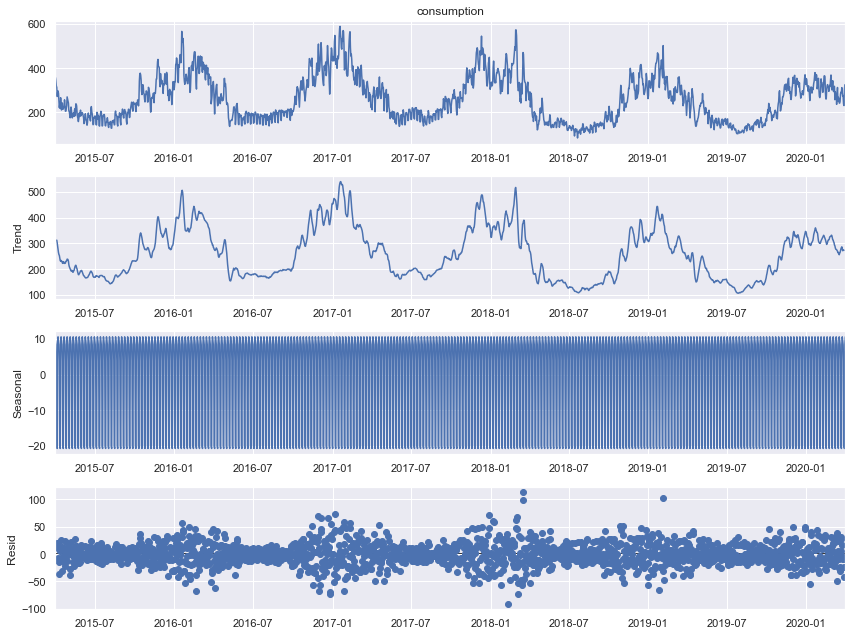

In [118]:
#@title Seasonal Decomposition
seasonally_decompose_series(df.consumption, 
                            mod_class='seasonal_decompose',
                            model='additive')

#### Decomposition of Target:
- Analyse ACF/PACF to attempt to establish parameters p, d, q
  - p: 1
  - d: ~6
  - q: ~6

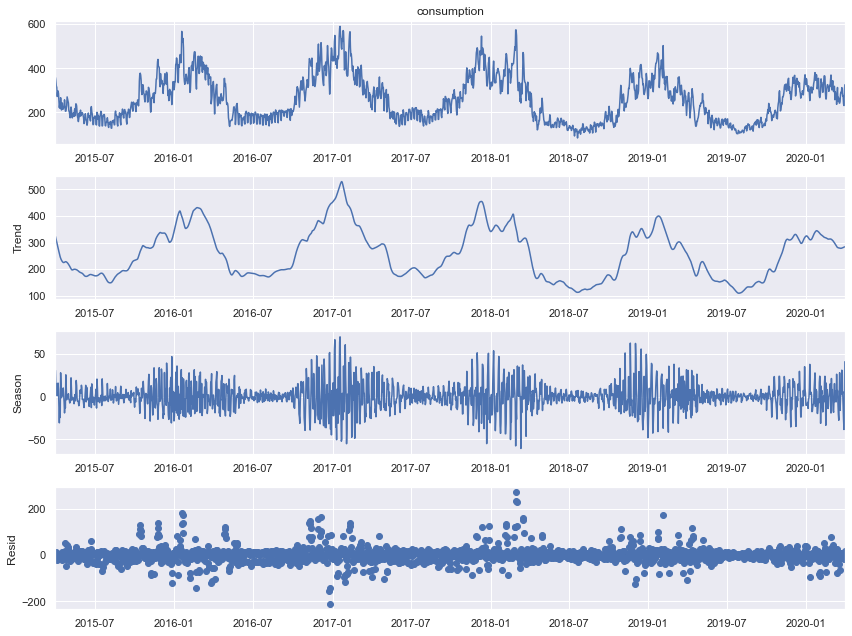

In [116]:
#@title Attempt more complex decomposition of target using LOESS.
seasonally_decompose_series(df.consumption, mod_class='stl', 
                            period=12, robust=True)

#### Analyse Time Series Structural Components
1. Find (P,D,Q,M) Order
Seasonal Component Stationarity
    - D-Order: 0
    - P-Order: 30
    - Q-Order: 28
2. Analyse Residual Distribution & Properties


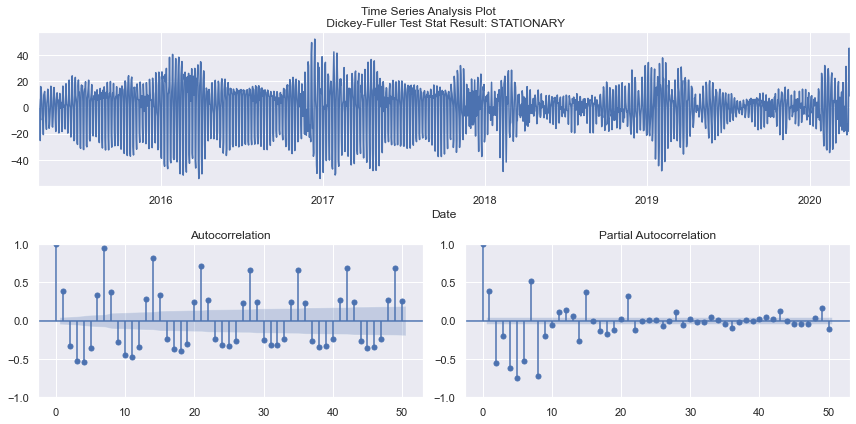

In [44]:
#@title 1. Seasonal Component 

# Fit STL model
ts_dc = sm.tsa.STL(df.consumption).fit()

# Check Stationarity
ts_plot(ts_dc.seasonal, lags=50)

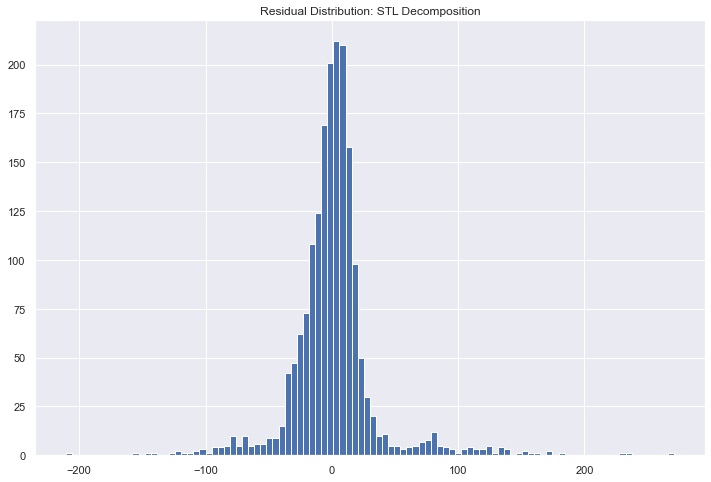

In [133]:
#@title Plot STL Residual Component
# Fit separate STL instance.
stl = sm.tsa.STL(s, period=12, robust=True).fit()

# Plot residuals
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(pd.Series(stl.resid), bins=100)
ax.set_title('Residual Distribution: STL Decomposition')
plt.show()